In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import datetime
from sklearn import preprocessing
from tensorflow.keras.callbacks import LearningRateScheduler, Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import glorot_normal
import tensorflow
import math
%matplotlib ipympl
%matplotlib inline
PATH_TO_PICKLED_DATA="data/Lab1"

In [2]:
def unpickle_dataset(file_path):
    try:
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Unable to load data from {file_path}, reason {e}")
X_train=unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/X_train")
y_train=to_categorical(unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/y_train"))
X_test=unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/X_test")
y_test=to_categorical(unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/y_test"))
X_valid=unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/X_valid")
y_valid=to_categorical(unpickle_dataset(f"{PATH_TO_PICKLED_DATA}/y_valid"))

In [3]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((453177, 784),
 (453177, 10),
 (15000, 784),
 (15000, 10),
 (20000, 784),
 (20000, 10))

In [8]:
def evaluate_model_with_drop_and_decay(hidden_activation_f, number_of_hidden_layers,
                                       num_of_epochs=10, batch_size=32,
                                       dropout_rate=None,
                                       optimizer='sgd', callbacks=None, kernel_regularizer=None, bias_regularizer=None,
                                       kernel_initializer='random_uniform', early_stopping=False, batch_noramlization=False
                                      ):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(784,)))
    for i in range(number_of_hidden_layers):
        model.add(tf.keras.layers.Dense(2**(10-i),
                                        kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
                                        kernel_initializer=kernel_initializer
                                       ))
        if batch_noramlization:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hidden_activation_f))
        if dropout_rate:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    if early_stopping:
        if callbacks is None:
            callbacks=[]
        callbacks.append(EarlyStopping(monitor='val_accuracy', mode='max', patience=7))
    model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
    history=model.fit(X_train, y_train, verbose=0, epochs=num_of_epochs,
            callbacks=callbacks,
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            shuffle=True)
    return model.evaluate(X_test,  y_test, verbose=0), history

In [5]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [7]:
results=[]
best_accuracy=0
best_model_history=None
iteration=0
printProgressBar(iteration, 5*3)
for num_of_layers in range(1, 6):
    for activation_f in ["sigmoid", "relu", "tanh"]:
        num_of_epochs=50
        batch_size=512
        (loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f=activation_f, 
                                                                     number_of_hidden_layers=num_of_layers,
                                                                    num_of_epochs=num_of_epochs, batch_size=batch_size,
                                                                    early_stopping=True)
        if accuracy>best_accuracy:
            best_model_history=history
        results.append({
            "name": f"NN_{activation_f}_{num_of_layers}",
            "activation": activation_f,
            "num_of_layers": num_of_layers,
            "num_of_epochs": num_of_epochs,
            "batch_size": batch_size,
            "loss": loss,
            "accuracy":accuracy
        })
        iteration+=1
        printProgressBar(iteration, 5*3)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [8]:
pd.DataFrame(results, columns=["name", "activation", "num_of_layers", "num_of_epochs", "batch_size", "loss", "accuracy"]).sort_values("accuracy", ascending=False).head(10)

,name,activation,num_of_layers,num_of_epochs,batch_size,loss,accuracy
10,NN_relu_4,relu,4,50,512,0.447843,0.86855
7,NN_relu_3,relu,3,50,512,0.469805,0.86320
4,NN_relu_2,relu,2,50,512,0.537473,0.84765
11,NN_tanh_4,tanh,4,50,512,0.567777,0.84295
14,NN_tanh_5,tanh,5,50,512,0.561854,0.83845
8,NN_tanh_3,tanh,3,50,512,0.633304,0.83730
5,NN_tanh_2,tanh,2,50,512,0.644241,0.83455
1,NN_relu_1,relu,1,50,512,0.641483,0.83090
2,NN_tanh_1,tanh,1,50,512,0.670478,0.82795
0,NN_sigmoid_1,sigmoid,1,50,512,1.555153,0.66135


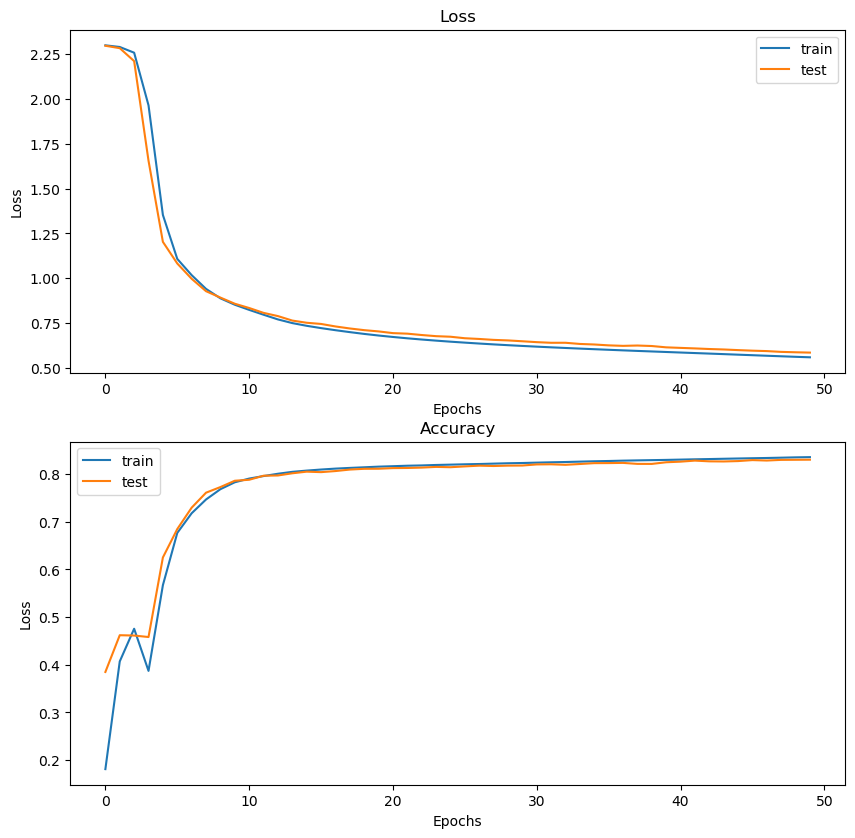

In [9]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history.history['loss'], label='train')
plt.plot(best_model_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history.history['accuracy'], label='train')
plt.plot(best_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [13]:
results=[]
best_accuracy_2=0
best_model_history_2=None
iteration=0
printProgressBar(iteration, 9)
for dropout_rate in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7]:
    (loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f="relu", 
                                                                     number_of_hidden_layers=4,
                                                                    num_of_epochs=50, batch_size=512, dropout_rate=dropout_rate,
                                                                    early_stopping=True
                                                                )
    if accuracy>best_accuracy_2:
        best_model_history_2=history
    results.append({
                    "name": "NN_relu_4",
                    "activation": "relu",
                    "num_of_layers": 2,
                    "num_of_epochs": 50,
                    "batch_size": 512,
                    "loss": loss,
                    "drop_out": dropout_rate,
                    "accuracy":accuracy
                })
    iteration+=1
    printProgressBar(iteration, 9)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [14]:
pd.DataFrame(results, columns=["drop_out", "loss", "accuracy"]).sort_values("accuracy", ascending=False).head(10)

,drop_out,loss,accuracy
3,0.1000,0.402821,0.87915
4,0.2000,0.405427,0.87900
2,0.0100,0.406655,0.87815
1,0.0010,0.408678,0.87715
5,0.3000,0.413669,0.87685
0,0.0001,0.410800,0.87645
6,0.4000,0.420835,0.87460
7,0.5000,0.436918,0.86880
8,0.7000,0.496175,0.85420


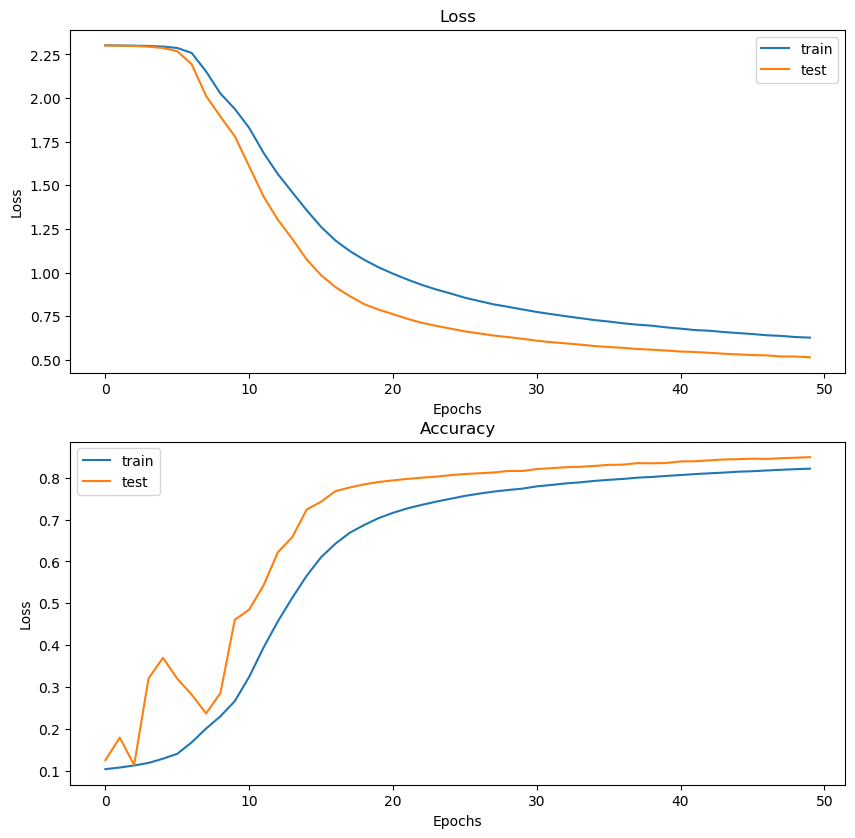

In [15]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_2.history['loss'], label='train')
plt.plot(best_model_history_2.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_2.history['accuracy'], label='train')
plt.plot(best_model_history_2.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [17]:
results=[]
best_accuracy_3=0
best_model_history_3=None
iteration=0
printProgressBar(iteration, 5)
for reg_strength in [0.01, 0.1, 1]:
    if reg_strength:
        kernel_regularizer=tf.keras.regularizers.l2(reg_strength)
        bias_regularizer=tf.keras.regularizers.l2(reg_strength)
    else:
        kernel_regularizer=None
        bias_regularizer=None
    (loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f="relu", 
                                                                     number_of_hidden_layers=4,
                                                                    num_of_epochs=50, batch_size=512,
                                                                kernel_regularizer=kernel_regularizer,
                                                                 bias_regularizer=bias_regularizer,
                                                                 early_stopping=True
                                                                )
    if accuracy>best_accuracy_3:
        best_model_history_3=history
    results.append({
                    "name": "NN_relu_4",
                    "activation": "relu",
                    "num_of_layers": 4,
                    "num_of_epochs": 50,
                    "batch_size": 512,
                    "loss": loss,
                    "reg_strength": reg_strength,
                    "accuracy":accuracy
                })
    iteration+=1
    printProgressBar(iteration, 5)

In [18]:
pd.DataFrame(results, columns=["name", "reg_strength", "loss", "accuracy"]).sort_values("accuracy", ascending=False).head(10)

,name,reg_strength,loss,accuracy
0,NN_relu_4,0.01,3.786271,0.1
1,NN_relu_4,0.10,2.303130,0.1
2,NN_relu_4,1.00,2.303154,0.1


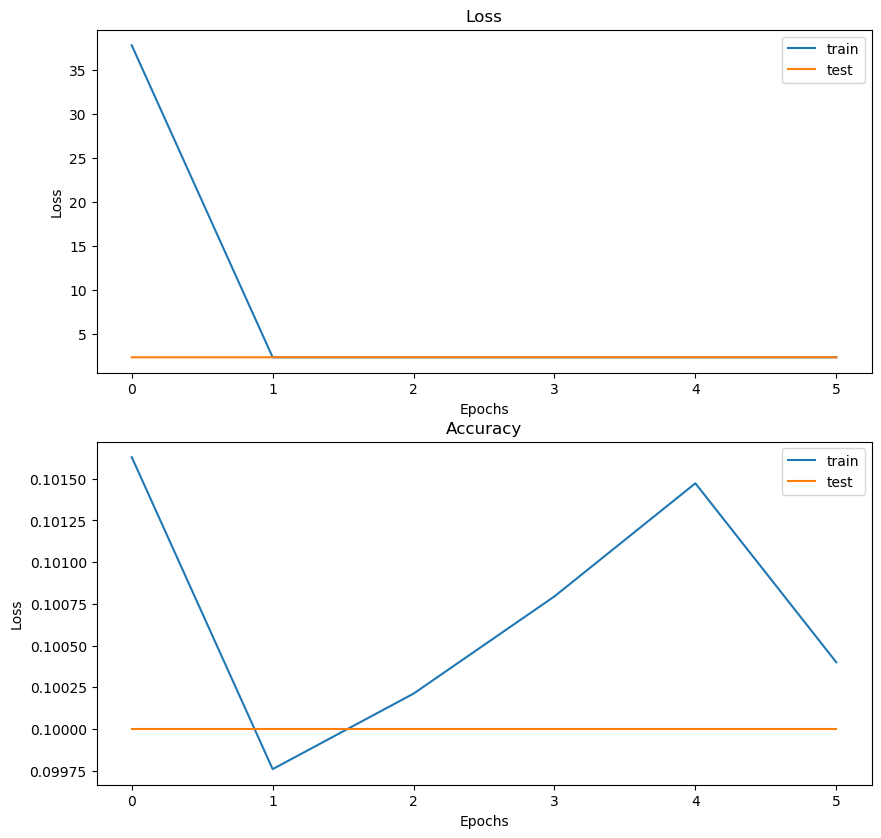

In [19]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_3.history['loss'], label='train')
plt.plot(best_model_history_3.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_3.history['accuracy'], label='train')
plt.plot(best_model_history_3.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [9]:
NUMBER_OF_EPOCHS=100

In [10]:
# LearningRate = InitialLearningRate * DropRate^floor(Epoch / EpochDrop)
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
step_decay_callbacks = [loss_history, lrate]

In [11]:
#lr = lr0 * e^(−kt)
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * math.exp(-k*epoch)
    return lrate

lrate = LearningRateScheduler(exp_decay)
loss_history = LossHistory()
exponential_decay_callbacks=[loss_history, lrate]

In [12]:
#LearningRate = LearningRate * 1/(1 + decay * epoch)
learning_rate = 0.1
decay_rate = learning_rate / NUMBER_OF_EPOCHS
momentum = 0.8
sgd_momentum = tensorflow.keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [13]:
adagard=tensorflow.keras.optimizers.Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
adadelta=tensorflow.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
rmsprop=tensorflow.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
adam=tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [14]:
results=[]
optimizers={
    "step_decay":step_decay_callbacks, 
    "exponential_decay": exponential_decay_callbacks,
    "momentum": sgd_momentum,
    "adagard": adagard,
    "adadelta": adadelta,
    "rmsprop": rmsprop,
    "adam": adam, 
}
best_accuracy_4=0
best_model_history_4=None
iteration=0
printProgressBar(iteration, 7)
for optim_name, optimizer in optimizers.items():
    if isinstance(optimizer, list):
        (loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f="relu", 
                                                                     number_of_hidden_layers=4,
                                                                    num_of_epochs=NUMBER_OF_EPOCHS, batch_size=512, dropout_rate=0.1, callbacks=optimizer,
                                                                      early_stopping=True
                                                                    )
    else:
        (loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f="relu", 
                                                                     number_of_hidden_layers=4,
                                                                    num_of_epochs=NUMBER_OF_EPOCHS, batch_size=512, dropout_rate=0.1, optimizer=optimizer,
                                                                     early_stopping=True
                                                                    )
    if accuracy>best_accuracy_4:
        best_model_history_4=history
    results.append({
        "name": f"NN_relu_4_{optim_name}",
        "loss": loss,
        "accuracy":accuracy,
        "optimizer": optim_name
    })
    iteration+=1
    printProgressBar(iteration, 7)


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [15]:
pd.DataFrame(results, columns=["name", "optimizer", "loss", "accuracy"]).sort_values("accuracy", ascending=False).head(10)

,name,optimizer,loss,accuracy
6,NN_relu_4_adam,adam,0.393748,0.92505
5,NN_relu_4_rmsprop,rmsprop,0.434549,0.92435
4,NN_relu_4_adadelta,adadelta,0.420911,0.92350
2,NN_relu_4_momentum,momentum,0.297283,0.91230
1,NN_relu_4_exponential_decay,exponential_decay,0.324569,0.90135
0,NN_relu_4_step_decay,step_decay,0.338988,0.89710
3,NN_relu_4_adagard,adagard,0.359442,0.88815


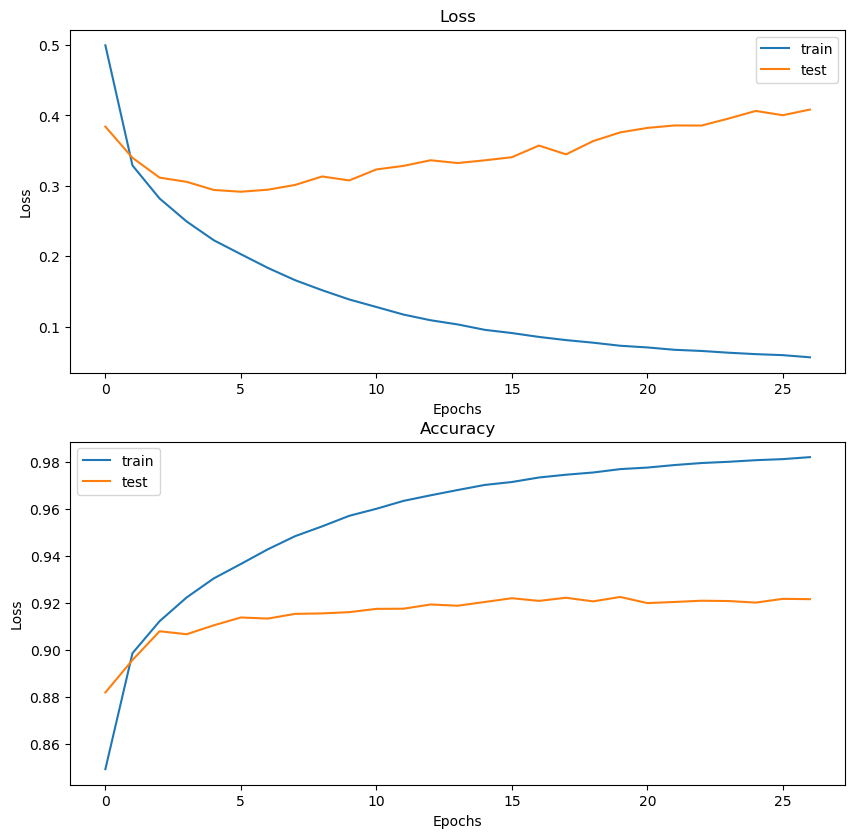

In [16]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_4.history['loss'], label='train')
plt.plot(best_model_history_4.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(best_model_history_4.history['accuracy'], label='train')
plt.plot(best_model_history_4.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [17]:
(loss, accuracy), history=evaluate_model_with_drop_and_decay(hidden_activation_f="relu", number_of_hidden_layers=4,num_of_epochs=100, batch_size=512, dropout_rate=0.1, optimizer=adam, kernel_initializer=glorot_normal(), early_stopping=True, batch_noramlization=True)

In [18]:
print(f"Model loss={loss}, accuracy={accuracy}")

Model loss=0.4056884394625862, accuracy=0.923550009727478


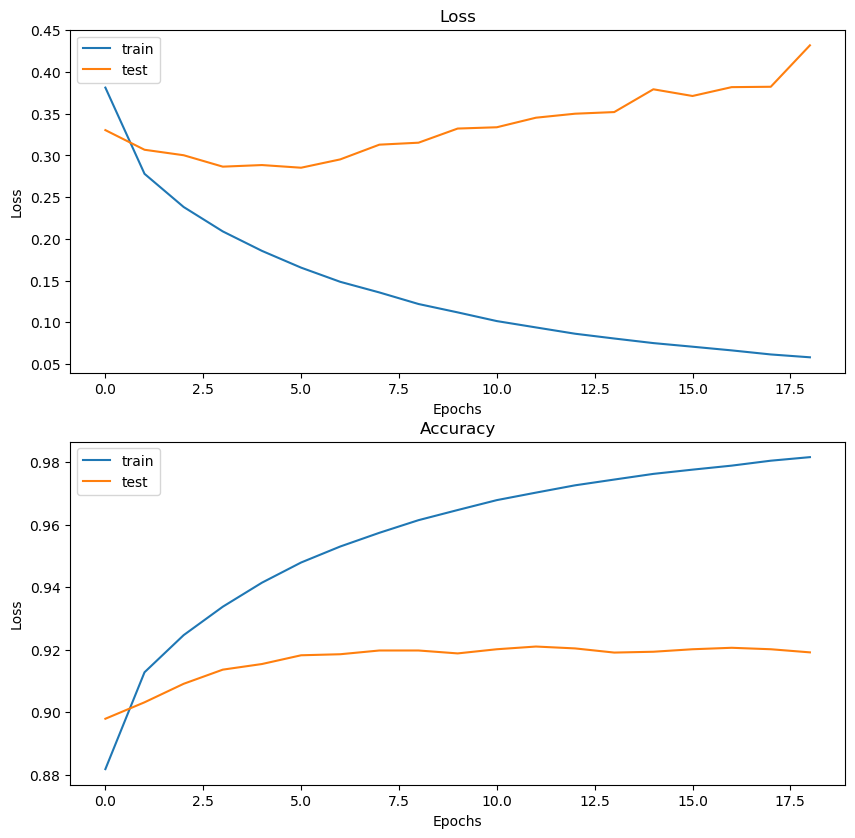

In [19]:
plt.figure(figsize=(10, 10), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()